# Model Rekomondasi

### Persiapaan Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack


In [2]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y
    
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [3]:
df = pd.read_csv('sentiment_2760.csv')
df.head(10)

,content,sentimen
0,ivan 31 pedagang sayur pasar kemiri muka depok...,negatif
1,pasukan militer israel operasi serangan tepi b...,negatif
2,suami berinisial 32 tega kekerasan rumah tangg...,negatif
3,menghambat pasokan bantuan penduduk gaza kejah...,negatif
4,praktik dunia kerap ditemukan perusahaan menah...,negatif
5,cawapres nomor urut 1 muhaimin iskandar cak im...,negatif
6,ketum pdi perjuangan pdip megawati soekarnoput...,negatif
7,pengguna lrt jabodebek mengeluhkan waktu tungg...,negatif
8,heboh media sosial isu anggota bem universitas...,negatif
9,mobil dipamerkan mal semarang jawa tengah hila...,negatif


In [4]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)


In [5]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]


In [6]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

# Bag of Words (BoW) features
count_vectorizer, count_train_features = bow_extractor(x_train)
count_test_features = count_vectorizer.transform(x_test)

# Combine TF-IDF and BoW features
combined_train_features = hstack([tfidf_train_features, count_train_features])
combined_test_features = hstack([tfidf_test_features, count_test_features])

In [7]:
# TF-IDF Features
print("Jumlah fitur TF-IDF:", tfidf_train_features.shape[1])

# Bag of Words (BoW) Features
print("Jumlah fitur Bag of Words:", count_train_features.shape[1])

# Combined Features
print("Jumlah fitur gabungan:", combined_train_features.shape[1])

Jumlah fitur TF-IDF: 128583
Jumlah fitur Bag of Words: 17831
Jumlah fitur gabungan: 146414


In [8]:
from sklearn.linear_model import LogisticRegression


In [9]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Define function to train and evaluate Naive Bayes classifier
def train_and_evaluate(classifier, train_features, train_labels, test_features, test_labels):
    # Train the classifier
    classifier.fit(train_features, train_labels)
    
    # Predictions
    predictions = classifier.predict(test_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predictions)
    
    # Calculate F1 score
    f1 = f1_score(test_labels, predictions, average='weighted')
    
    # Classification report
    report = classification_report(test_labels, predictions, target_names=label_encoder.classes_)
    
    # Confusion matrix
    matrix = confusion_matrix(test_labels, predictions)
    
    return accuracy * 100, f1 * 100, report, matrix

In [11]:
# Function to plot confusion matrix
def plot_confusion_matrix(matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#### Parameter

In [12]:
# Initialize Naive Bayes classifier
lr_parameter =  LogisticRegression(C=0.1,max_iter=1000)

## Train and evaluate on Bag of Words (BoW) features
bow_accuracy, bow_f1,bow_report,bow_matrix = train_and_evaluate(lr_parameter , count_train_features, y_train_encoded, count_test_features, y_test_encoded)


In [13]:
print("Bag of Words (BoW) Features:")
print("Accuracy: {:.2f}%".format(bow_accuracy))
print("F1 Score: {:.2f}%".format(bow_f1))
print("Classification Report:\n", bow_report)
print("Confusion Matrix:\n", bow_matrix)

Bag of Words (BoW) Features:
Accuracy: 93.72%
F1 Score: 93.70%
Classification Report:
               precision    recall  f1-score   support

     negatif       0.96      0.88      0.92       272
      netral       0.89      0.99      0.94       280
     positif       0.97      0.94      0.95       276

    accuracy                           0.94       828
   macro avg       0.94      0.94      0.94       828
weighted avg       0.94      0.94      0.94       828

Confusion Matrix:
 [[240  25   7]
 [  2 276   2]
 [  8   8 260]]


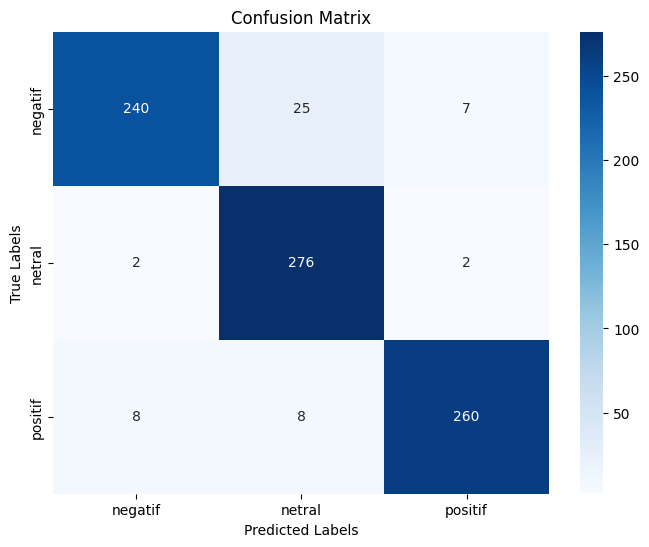

In [14]:
# Plot confusion matrix
plot_confusion_matrix(bow_matrix, label_encoder.classes_)

In [15]:
import joblib

In [16]:
# # Save the trained model to a file
# joblib.dump(lr_parameter, 'logistic_regression_model.pkl')

# # Later, to load the model from the file
# loaded_model = joblib.load('logistic_regression_model.pkl')

In [17]:
# # Load the trained model from the file
# loaded_model = joblib.load('logistic_regression_model.pkl')

# # Example text data for prediction
# new_data = ["bogor keluarga fw 22 perempuan dibunuh pacarnya ra alias alung 20 bogor pelaku dihukum berat ayah korban iwan irawan terima alung dihukum 15 tahun penjara sesuai pasal 338 kuhp pembunuhan iwan berharap alung dihukum seberat beratnya penjara seumur hidup baca wanita dibunuh pacarnya bogor mulutnya dibekap hidungnya digigit kepolisian hukum seberat beratnya seadil adilnya nyawa anak keberatan 15 tahun harapannya seumur hidup iwan ditemui mapolresta bogor kota selasa 5 12 2023 iwan menyangka kekasih anaknya pelaku pembunuh darah dagingnya hubungan asmara terjalin tahun setahun kenal dianggap anak main rumah iwan timbal baliknya bohong anak meninggal jatuh motor dibunuh sambung baca bekap pacar tewas bogor pelaku niat membunuhsejak peristiwa tragis iwan keluarga tersangka iktikad pemakaman anaknya keluarga tersangka keluarga tersangka iktikad baiknya ga komunikasinya iwan nyawa aja pertemuan pemakaman sambung", 
#             "calon presiden bacapres ganjar pranowo mengawali aktivitasnya berlari seputaran kota bandung jawa barat pria berambut putih menyusuri gang gang pemukiman warga"]

# # Vectorize the new data using the same CountVectorizer used for training
# new_data_features = count_vectorizer.transform(new_data)

# # Predict sentiment using the loaded model
# predictions = loaded_model.predict(new_data_features)

# # Decode numerical labels back to text labels
# predicted_sentiments = label_encoder.inverse_transform(predictions)

# # Print the predicted sentiments
# for text, sentiment in zip(new_data, predicted_sentiments):
#     print(f"Text: '{text}' -> Predicted Sentiment: '{sentiment}'")

In [18]:
# Dictionary to store model and vectorizer
model_data = {
    'model': lr_parameter,  # your trained Logistic Regression model
    'vectorizer': count_vectorizer,
    'label_encoder': label_encoder
}

# Save the model data to a file
joblib.dump(model_data, 'logistic_regression_with_vectorizer_baru.pkl')

['logistic_regression_with_vectorizer_baru.pkl']

In [19]:
# # Later, to load the model data from the file
# loaded_model_data = joblib.load('logistic_regression_with_vectorizer.pkl')

# # Extract model and vectorizer from loaded data
# loaded_model = loaded_model_data['model']
# loaded_vectorizer = loaded_model_data['vectorizer']
# new_data = ["bogor keluarga fw 22 perempuan dibunuh pacarnya ra alias alung 20 bogor pelaku dihukum berat ayah korban iwan irawan terima alung dihukum 15 tahun penjara sesuai pasal 338 kuhp pembunuhan iwan berharap alung dihukum seberat beratnya penjara seumur hidup baca wanita dibunuh pacarnya bogor mulutnya dibekap hidungnya digigit kepolisian hukum seberat beratnya seadil adilnya nyawa anak keberatan 15 tahun harapannya seumur hidup iwan ditemui mapolresta bogor kota selasa 5 12 2023 iwan menyangka kekasih anaknya pelaku pembunuh darah dagingnya hubungan asmara terjalin tahun setahun kenal dianggap anak main rumah iwan timbal baliknya bohong anak meninggal jatuh motor dibunuh sambung baca bekap pacar tewas bogor pelaku niat membunuhsejak peristiwa tragis iwan keluarga tersangka iktikad pemakaman anaknya keluarga tersangka keluarga tersangka iktikad baiknya ga komunikasinya iwan nyawa aja pertemuan pemakaman sambung", 
#             "calon presiden bacapres ganjar pranowo mengawali aktivitasnya berlari seputaran kota bandung jawa barat pria berambut putih menyusuri gang gang pemukiman warga"]

# # Extract model, vectorizer, and label encoder from loaded data
# loaded_model = loaded_model_data['model']
# loaded_vectorizer = loaded_model_data['vectorizer']
# loaded_label_encoder = loaded_model_data['label_encoder']

# # Vectorize the new data using the loaded CountVectorizer
# new_data_features = loaded_vectorizer.transform(new_data)

# # Predict sentiment using the loaded model
# predictions = loaded_model.predict(new_data_features)

# # Decode numerical labels back to text labels using the loaded LabelEncoder
# predicted_sentiments = loaded_label_encoder.inverse_transform(predictions)

# # Print the predicted sentiments
# for text, sentiment in zip(new_data, predicted_sentiments):
#     print(f"Text: '{text}' -> Predicted Sentiment: '{sentiment}'")

In [20]:
# import joblib

# # Dictionary to store model, vectorizer, and label encoder
# model_data = {
#     'model': lr_parameter,  # your trained Logistic Regression model
#     'vectorizer': count_vectorizer,  # your trained CountVectorizer
#     'label_encoder': label_encoder  # your trained LabelEncoder
# }

# # Save the model data to a file
# joblib.dump(model_data, 'logistic_regression_with_vectorizer.joblib')